# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [153]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

### Data Loading

Here, we load the police call data for five years (2018-2022) from CSV files. The data is then concatenated into a single DataFrame for analysis.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [5]:
# For testing purposes, just use one year's worth of data
police_csv_files = glob.glob("data/police/*.neighborhood.csv")

# List to hold dataframes
police_dfs = []

# Loop through the list of files and read them into dataframes
for file in police_csv_files:
    df = pd.read_csv(file)
    police_dfs.append(df)

# Concatenate all dataframes into one
all_police_df = pd.concat(police_dfs, ignore_index=True)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 1539081


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [7]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
812278,20210821014809PD,8741224,8/21/2021 12:00:00 AM,P212330070,6,8/21/2021 12:00:00 AM,8/21/2021 12:00:00 AM,01:10:55,1195,VEHICLE STOP,N,No report required; dispatch record only,[1600]-[1700] SARALYNN DR,San Jose,CA,37.314788,-121.821044,West Evergreen
774376,20210707180252PD,8682611,7/7/2021 12:00:00 AM,P211880761,2,7/7/2021 12:00:00 AM,7/7/2021 12:00:00 AM,16:53:22,WELCK,WELFARE CHECK,N,No report required; dispatch record only,[200]-[300] MONTCLAIR AV,San Jose,CA,37.365508,-121.846944,Alexian and Jackson
266801,20181026233923PD,7403281,5/14/2021 12:00:00 AM,P182991085,4,10/26/2018 12:00:00 AM,10/26/2018 12:00:00 AM,21:58:57,415,DISTURBANCE,G,Gone on Arrival/unable to loca,[500]-[600] HORNING ST,San Jose,CA,37.361194,-121.893044,Hyde Park
295496,20181129194713PS,7447211,5/14/2021 12:00:00 AM,P183330770,2,11/29/2018 12:00:00 AM,11/29/2018 12:00:00 AM,19:18:25,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch r,[300]-[400] TRADEWINDS DR,San Jose,CA,37.253720,-121.826375,Oak Grove
1503016,20221113195125PS,9324418,11/13/2022 12:00:00 AM,P223170635,2,11/13/2022 12:00:00 AM,11/13/2022 12:00:00 AM,19:15:16,WELCK,WELFARE CHECK,N,No report required; dispatch record only,[2300]-[2400] ALUM ROCK AV,San Jose,CA,37.349547,-121.862248,Five Wounds-San Jose High


In [8]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539081 entries, 0 to 1539080
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   CDTS              1539081 non-null  object 
 1   EID               1539081 non-null  int64  
 2   START_DATE        1539081 non-null  object 
 3   CALL_NUMBER       1539081 non-null  object 
 4   PRIORITY          1539081 non-null  int64  
 5   REPORT_DATE       1539081 non-null  object 
 6   OFFENSE_DATE      1539081 non-null  object 
 7   OFFENSE_TIME      1539081 non-null  object 
 8   CALLTYPE_CODE     1539081 non-null  object 
 9   CALL_TYPE         1539052 non-null  object 
 10  FINAL_DISPO_CODE  1539081 non-null  object 
 11  FINAL_DISPO       1539081 non-null  object 
 12  ADDRESS           1493196 non-null  object 
 13  CITY              1539081 non-null  object 
 14  STATE             1539081 non-null  object 
 15  LATITUDE          1382253 non-null  float64
 16  

In [13]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,1.539081e+06,1.539081e+06,1.382253e+06,1.382253e+06
mean,8.180701e+06,3.306330e+00,3.732166e+01,-1.218714e+02
std,6.868815e+05,1.403320e+00,4.271746e-02,4.756362e-02
min,7.000038e+06,1.000000e+00,3.401807e+01,-1.220357e+02
25%,7.585737e+06,2.000000e+00,3.729838e+01,-1.219025e+02
50%,8.180582e+06,3.000000e+00,3.732482e+01,-1.218696e+02
75%,8.772205e+06,4.000000e+00,3.734928e+01,-1.218387e+02
max,9.383082e+06,6.000000e+00,3.753923e+01,-1.179118e+02


In [15]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,1539081,1539081,1539081,1539081,1539081,1539081,1539081,1539052,1539081,1539081,1493196,1539081,1539081,1375316
unique,1529044,557,1507152,1820,1820,86381,223,238,22,25,67985,1,1,295
top,20221204123543PS,5/14/2021 12:00:00 AM,P221220700,7/4/2021 12:00:00 AM,7/4/2021 12:00:00 AM,18:15:00,415,DISTURBANCE,N,No report required; dispatch r,[200]-[300] W MISSION ST,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,644989,7,1116,1116,47,151902,151900,710509,483883,4479,1539081,1539081,42998


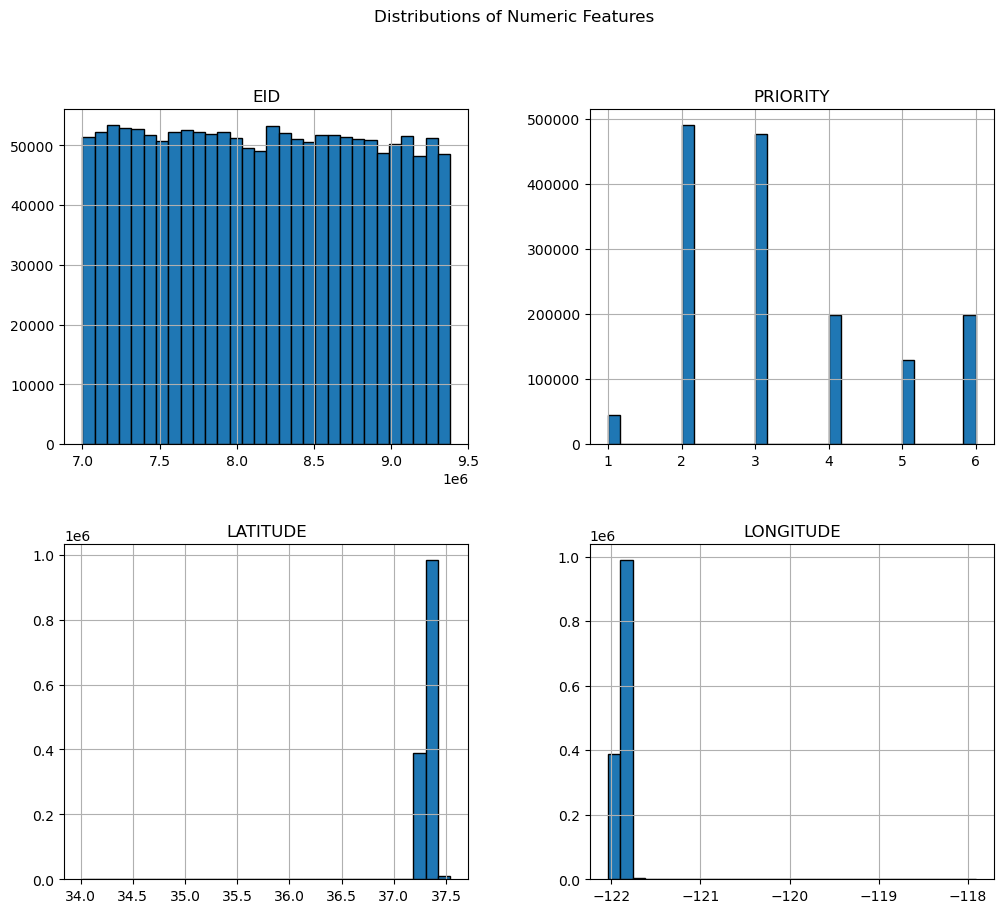

In [16]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [17]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                     0
EID                      0
START_DATE               0
CALL_NUMBER              0
PRIORITY                 0
REPORT_DATE              0
OFFENSE_DATE             0
OFFENSE_TIME             0
CALLTYPE_CODE            0
CALL_TYPE               29
FINAL_DISPO_CODE         0
FINAL_DISPO              0
ADDRESS              45885
CITY                     0
STATE                    0
LATITUDE            156828
LONGITUDE           156828
neighborhood        163765
dtype: int64

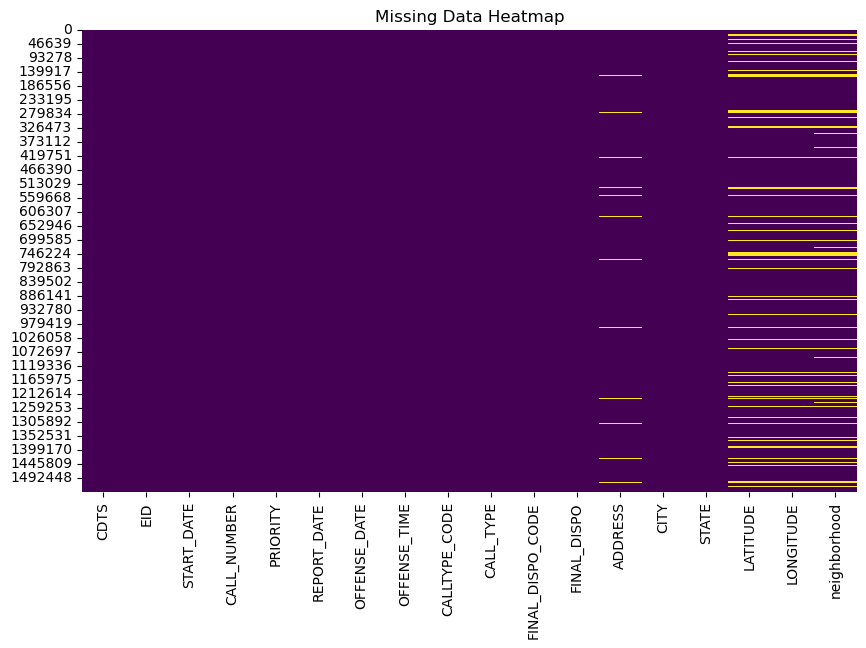

In [18]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [19]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 1529044 unique values
START_DATE: 557 unique values
CALL_NUMBER: 1507152 unique values
REPORT_DATE: 1820 unique values
OFFENSE_DATE: 1820 unique values
OFFENSE_TIME: 86381 unique values
CALLTYPE_CODE: 223 unique values
CALL_TYPE: 238 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 25 unique values
ADDRESS: 67985 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [23]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          710509
CAN        241059
R          174946
G           91422
D           47185
E           44456
O           29029
A           27573
DUPNCAN     26535
GD          22855
U           20810
NR          19676
H           18966
C           16213
T           15193
ADV         14145
B           13193
F            4412
M             317
Z             278
P             218
TOT            91
Name: count, dtype: int64

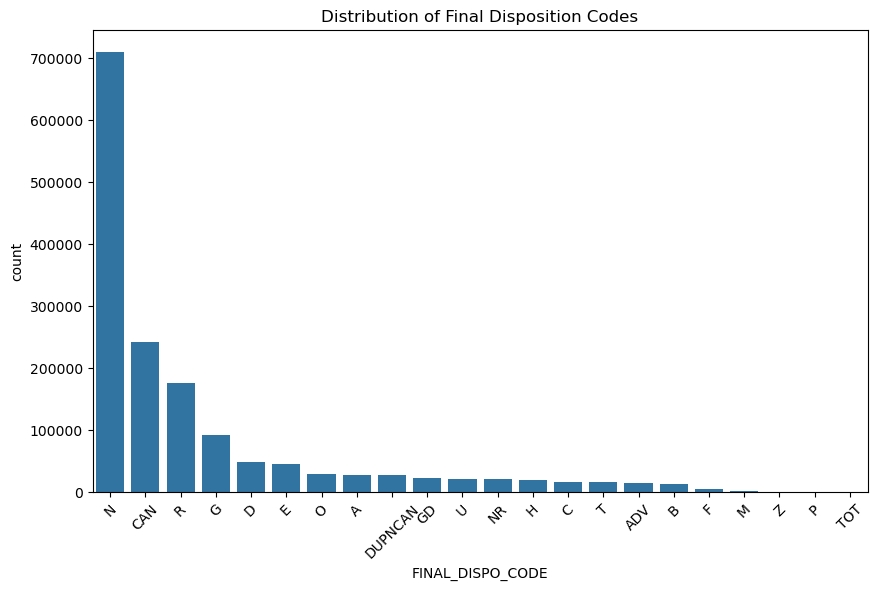

In [24]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [25]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r                      483883
Canceled                                            241059
No report required; dispatch record only            226626
Report taken                                        174946
Gone on Arrival/unable to loca                       66373
No Disposition                                       63904
Traffic Citation Issued, Non-H                       34966
Supplemental report taken                            29029
Traffic Citation Issued, Hazar                       27920
Arrest Made                                          27573
Gone on Arrival/unable to locate                     25049
Unfounded event                                      20810
No Response                                          19676
Traffic Citation Issued, Hazardous Violation         19265
Criminal Citation                                    16213
Turned over To (TOT)                                 15193
Courtesy Service/Citizen or ag              

In [26]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch record only',
 'NR': 'No Response',
 'CAN': 'Canceled',
 'R': 'Report taken',
 'G': 'Gone on Arrival/unable to locate',
 'H': 'Courtesy Service/Citizen or agency assist',
 'GD': 'No Disposition',
 'DUPNCAN': 'No Disposition',
 'O': 'Supplemental report taken',
 'T': 'Turned over To (TOT)',
 'A': 'Arrest Made',
 'U': 'Unfounded event',
 'B': 'Arrest by Warrant',
 'E': 'Traffic Citation Issued, Non-Hazardous Violation',
 'ADV': 'No Disposition',
 'D': 'Traffic Citation Issued, Hazardous Violation',
 'C': 'Criminal Citation',
 'F': 'Field Interview (F.I.) Completed',
 'Z': 'No Disposition',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity only',
 'TOT': 'No Disposition'}

In [28]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 '1033A': 'ALARM, AUDIBLE',
 '415M': 'DISTURBANCE, MUSIC',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1057': 'FIREARMS DISCHARGED',
 'DVRO': 'VIOLATION OF PROTECTIVE ORDER',
 '415': 'DISTURBANCE',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAMAGE',
 '5150': 'MENTALLY DISTURBED PERSON',
 '23103': 'RECKLESS DRIVING',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '242': 'BATTERY',
 '415F': 'DISTURBANCE, FAMILY',
 '10851': 'STOLEN VEHICLE',
 'AID': 'PUBLIC SAFETY ASSISTANCE',
 '1070': 'PROWLER',
 '415W': 'DISTURBANCE, WEAPON',
 '1066': 'SUSPICIOUS PERSON',
 'WELCK': 'WELFARE CHECK',
 '415A': 'DISTURBANCE, FIGHT',
 '911UNK': 'UNK TYPE 911 CALL',
 '1195': 'VEHICLE STOP',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '415AEMS': 'DISTURBANCE, FIGHT (COMBINED EVENT)',
 '1125': 'TRAFFIC HAZARD',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '1091C': 'INJURED ANIMAL',
 '246': 'SHOOTING INTO OCCP VEH OR DWELLING',
 '23152': 'MISDEMEANOR DUI',
 '1091A': 'VICIOUS ANIMAL',
 '6F': 'FELONY 

## Focus on Target Dispositions

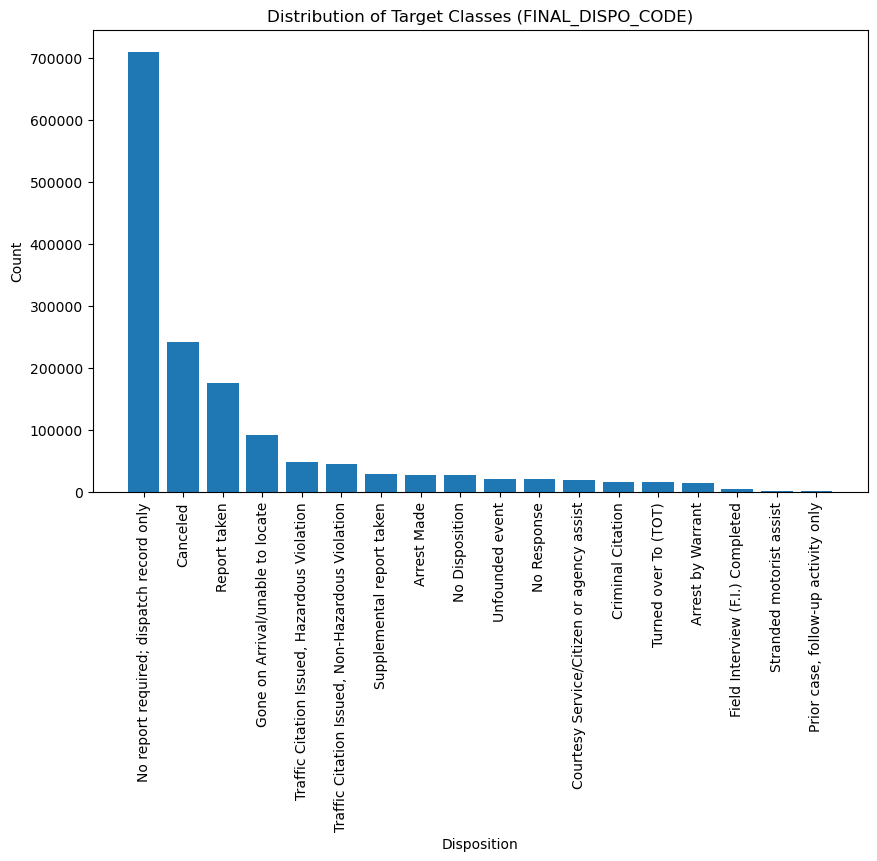

In [36]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [38]:
# List of target disposition codes to keep as individual classes
target_dispo_codes = ['A', 'B', 'C']

dispo_mapping = {
    'A': 'Arrest Made',
    'B': 'Arrest by Warrant',
    'C': 'Criminal Citation',
    'Other': 'Other'
}

In [40]:
# Step 1: Create a new target variable where specified disposition codes remain,
# and all others are consolidated into a single class.
all_police_df['DISPO_SUBSET'] = np.where(all_police_df['FINAL_DISPO_CODE'].isin(target_dispo_codes), 
                                         all_police_df['FINAL_DISPO_CODE'], 'Other')
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    1482102
A          27573
C          16213
B          13193
Name: count, dtype: int64

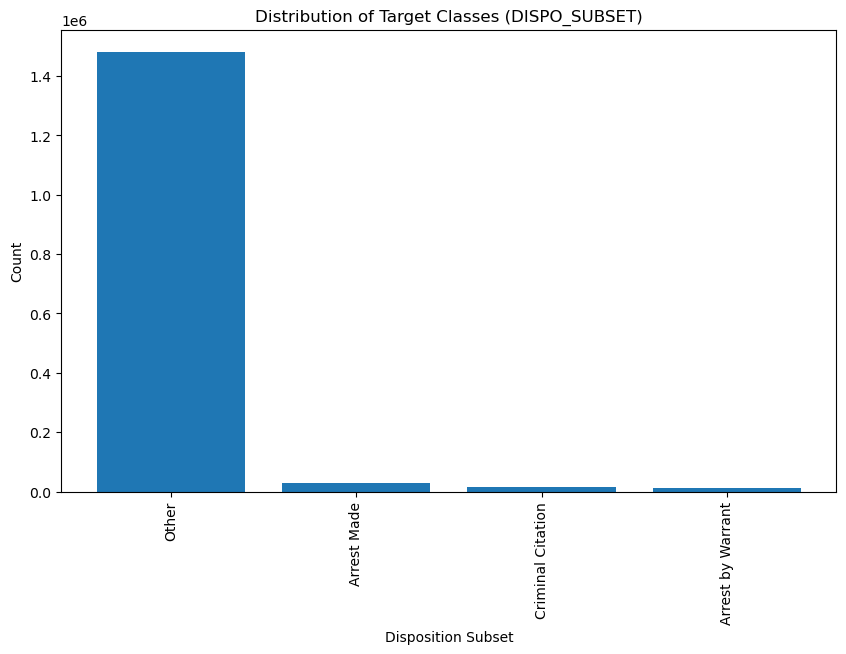

In [42]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Subset')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [45]:
# Remove rows with any missing values from the Police Calls dataset
police_calls_clean = all_police_df.dropna()
print(f"Police Calls Dataset: {all_police_df.shape[0]} rows before cleaning, {police_calls_clean.shape[0]} rows after cleaning.")

Police Calls Dataset: 1539081 rows before cleaning, 1375290 rows after cleaning.


In [46]:
# Dropping unnecessary columns 
police_calls_clean = police_calls_clean.drop( \
    columns=['CDTS', 'EID', 'CALL_NUMBER', 'START_DATE', 'REPORT_DATE', 'CITY', 'STATE', \
             'CALL_TYPE', 'FINAL_DISPO', 'FINAL_DISPO_CODE', 'ADDRESS'])

In [49]:
# Convert 'OFFENSE_DATE' to datetime to extract time-related features
police_calls_clean['OFFENSE_DATE'] = pd.to_datetime(police_calls_clean['OFFENSE_DATE'], format='%m/%d/%Y %I:%M:%S %p')

# and adding time-related features
police_calls_clean['OFFENSE_HOUR'] = police_calls_clean['OFFENSE_DATE'].dt.hour
police_calls_clean['OFFENSE_DAY_OF_WEEK'] = police_calls_clean['OFFENSE_DATE'].dt.dayofweek
police_calls_clean['OFFENSE_MONTH'] = police_calls_clean['OFFENSE_DATE'].dt.month

# Drop 'OFFENSE_DATE' now that features have been extracted
police_calls_clean = police_calls_clean.drop(columns=['OFFENSE_DATE', 'OFFENSE_TIME'])

# Distance from center: add a feature that
# San Jose's approximate center (Latitude and Longitude)
SJ_CENTER_LAT, SJ_CENTER_LON = 37.3382, -121.8863

# Calculate Euclidean distance from the city center
police_calls_clean['DISTANCE_FROM_CENTER'] = np.sqrt(
    (police_calls_clean['LATITUDE'] - SJ_CENTER_LAT) ** 2 + 
    (police_calls_clean['LONGITUDE'] - SJ_CENTER_LON) ** 2
)

In [51]:
# Normalize latitude and longitude before adding polynomial featuers
scaler = StandardScaler()
police_calls_clean[['LATITUDE', 'LONGITUDE']] = scaler.fit_transform(police_calls_clean[['LATITUDE', 'LONGITUDE']])

# Generate polynomial features from normalized latitude and longitude
poly = PolynomialFeatures(degree=2, include_bias=False)
lat_lon_poly = poly.fit_transform(police_calls_clean[['LATITUDE', 'LONGITUDE']])

# Create a DataFrame with the polynomial features and concatenate with original data
lat_lon_poly_df = pd.DataFrame(lat_lon_poly[:, 2:], \
                               columns=poly.get_feature_names_out(['LATITUDE', 'LONGITUDE'])[2:], \
                               index=police_calls_clean.index)

In [53]:
police_calls_clean = pd.concat([police_calls_clean, lat_lon_poly_df], axis=1)

In [55]:
# Encode categorical columns using One-Hot Encoding
police_calls_encoded = pd.get_dummies(police_calls_clean, columns=['CALLTYPE_CODE', 'neighborhood'], drop_first=True)

## Define X and Y

In [58]:
# Define features and target
X = police_calls_encoded.drop(columns=['DISPO_SUBSET'])
y = police_calls_encoded['DISPO_SUBSET']

In [60]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [62]:
label_encoder.classes_

array(['A', 'B', 'C', 'Other'], dtype=object)

In [64]:
label_names = [dispo_mapping[code] for code in label_encoder.classes_]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_original = label_encoder.inverse_transform(y_test)
y_test_original_name = [dispo_mapping[code] for code in y_test_original]

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [67]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [68]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [69]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      5030
Arrest by Warrant       0.00      0.00      0.00      2387
Criminal Citation       0.00      0.00      0.00      2901
            Other       0.96      1.00      0.98    264740

         accuracy                           0.96    275058
        macro avg       0.24      0.25      0.25    275058
     weighted avg       0.93      0.96      0.94    275058



### Logistic Regression

In [75]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print("DONE")

DONE


In [76]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.60      0.25      0.35      5030
Arrest by Warrant       0.70      0.58      0.63      2387
Criminal Citation       0.49      0.23      0.31      2901
            Other       0.98      0.99      0.99    264740

         accuracy                           0.97    275058
        macro avg       0.69      0.51      0.57    275058
     weighted avg       0.96      0.97      0.96    275058



#### Hyperparameter Tuning

In [78]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'] 
}

grid_search_scoring_method = 'f1_macro'

# Initialize Grid Search
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=-1, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced']},
             scoring='f1_macro', verbose=1)

In [79]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 100, 'class_weight': None}
Best Score (f1_macro): 0.5696


In [99]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, "best_logistic_regression.pkl") 

['best_logistic_regression.pkl']

In [101]:
# load
best_lr = joblib.load("best_logistic_regression.pkl")

In [103]:
y_pred_best_lr = best_lr.predict(X_test_scaled)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.60      0.25      0.35      5030
Arrest by Warrant       0.69      0.58      0.63      2387
Criminal Citation       0.49      0.23      0.31      2901
            Other       0.98      0.99      0.99    264740

         accuracy                           0.97    275058
        macro avg       0.69      0.51      0.57    275058
     weighted avg       0.96      0.97      0.96    275058



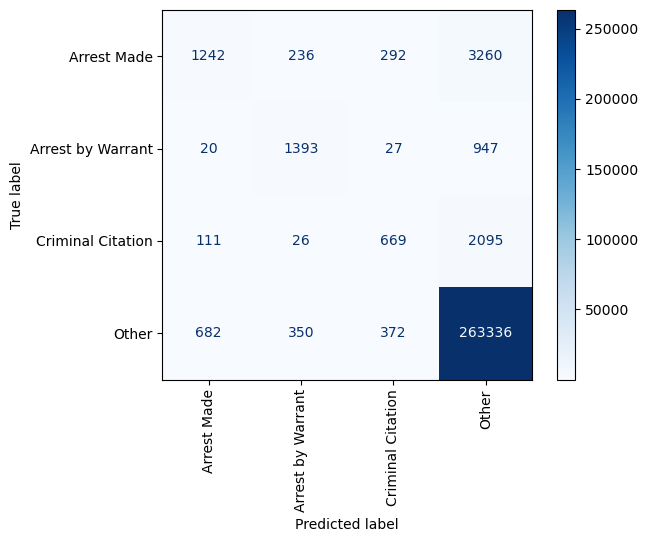

In [105]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test_scaled, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

#### Feature Importance

In [83]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
permutation_importance_result = permutation_importance(best_lr, X_test_scaled, y_test, n_repeats=5, random_state=42)

In [84]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping[code]
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top 10 features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(15)
print(top_perm_features)

                  Feature  Importance                           Call Type
201      CALLTYPE_CODE_6M    0.005307                    MISDEMEANOR WANT
200      CALLTYPE_CODE_6F    0.003294                         FELONY WANT
62    CALLTYPE_CODE_11300    0.002522                           NARCOTICS
186    CALLTYPE_CODE_601T    0.002011                       TRUANT (TABS)
67    CALLTYPE_CODE_11377    0.001728             POSSESSION OF NARCOTICS
110   CALLTYPE_CODE_23152    0.001600                     MISDEMEANOR DUI
83    CALLTYPE_CODE_12020    0.000920                     ILLEGAL WEAPONS
89      CALLTYPE_CODE_148    0.000856                    RESISTING ARREST
47   CALLTYPE_CODE_10851R    0.000823            RECOVERED STOLEN VEHICLE
87    CALLTYPE_CODE_14601    0.000707         DRIVING W/SUSPENDED LICENSE
0                PRIORITY    0.000580                                    
168     CALLTYPE_CODE_484    0.000535                               THEFT
56     CALLTYPE_CODE_1095    0.000479 

In [113]:
for index, coefficients in enumerate(best_lr.coef_):
    # Get the model's coefficients
    # coefficients = best_lr.coef_[0]
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_10_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)
    
    # Display the top 10 most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_10_features[['Feature', 'Coefficient', 'Call Type']])


label = Arrest Made
                  Feature  Coefficient                      Call Type
47   CALLTYPE_CODE_10851R     0.379455       RECOVERED STOLEN VEHICLE
11    CALLTYPE_CODE_1033A    -0.300251                 ALARM, AUDIBLE
105   CALLTYPE_CODE_22500    -0.288480              PARKING VIOLATION
110   CALLTYPE_CODE_23152     0.233557                MISDEMEANOR DUI
221    CALLTYPE_CODE_DVRO     0.214335  VIOLATION OF PROTECTIVE ORDER
45    CALLTYPE_CODE_10851     0.211700                 STOLEN VEHICLE
203  CALLTYPE_CODE_911UNK    -0.197731              UNK TYPE 911 CALL
186    CALLTYPE_CODE_601T     0.195500                  TRUANT (TABS)
151    CALLTYPE_CODE_415M    -0.189789             DISTURBANCE, MUSIC
144    CALLTYPE_CODE_415F     0.181845            DISTURBANCE, FAMILY

label = Arrest by Warrant
                  Feature  Coefficient                 Call Type
78     CALLTYPE_CODE_1195     0.259206              VEHICLE STOP
201      CALLTYPE_CODE_6M     0.244770          MISD

### Random Forest

In [115]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs = 2)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=2, random_state=42)

In [116]:
y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.41      0.26      0.32      5030
Arrest by Warrant       0.44      0.51      0.47      2387
Criminal Citation       0.25      0.25      0.25      2901
            Other       0.98      0.98      0.98    264740

         accuracy                           0.96    275058
        macro avg       0.52      0.50      0.51    275058
     weighted avg       0.95      0.96      0.96    275058



#### Hyperparameter Tuning

In [121]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 30]
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                              cv=5, n_jobs=-1, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'max_depth': None, 'n_estimators': 200}
Best Score (f1_macro): 0.51


In [193]:
best_rf = grid_rf.best_estimator_
# save
joblib.dump(best_rf, "best_random_forest.pkl") 

['best_random_forest.pkl']

In [195]:
best_rf = joblib.load("best_random_forest.pkl")

In [197]:
# Use the best estimator to make predictions

y_pred_best_rf = best_rf.predict(X_test_scaled)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.42      0.26      0.32      5030
Arrest by Warrant       0.44      0.51      0.47      2387
Criminal Citation       0.25      0.26      0.26      2901
            Other       0.98      0.98      0.98    264740

         accuracy                           0.96    275058
        macro avg       0.52      0.50      0.51    275058
     weighted avg       0.95      0.96      0.96    275058



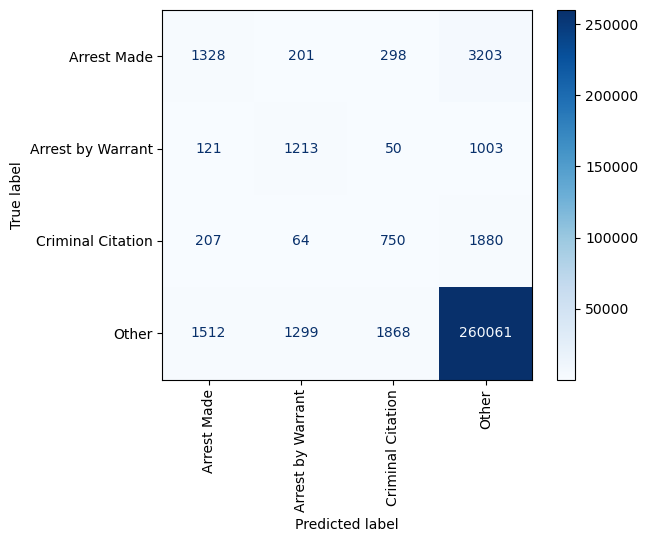

In [199]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_scaled, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

### Multilayer Perceptron Model

In [132]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for 3 epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [134]:
# Build the MLP model
mlp_model = Sequential()
mlp_model.add(Input(shape=(X_train_scaled.shape[1],)))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.2))  # Optional dropout to prevent overfitting
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [136]:
# Train the model
history = mlp_model.fit(X_train_scaled, y_train, epochs=10, batch_size=128, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9630 - loss: 0.1521 - val_accuracy: 0.9692 - val_loss: 0.1181
Epoch 2/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9675 - loss: 0.1214 - val_accuracy: 0.9690 - val_loss: 0.1169
Epoch 3/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9682 - loss: 0.1188 - val_accuracy: 0.9683 - val_loss: 0.1165
Epoch 4/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9682 - loss: 0.1172 - val_accuracy: 0.9689 - val_loss: 0.1159
Epoch 5/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9680 - loss: 0.1184 - val_accuracy: 0.9690 - val_loss: 0.1162
Epoch 6/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9684 - loss: 0.1165 - val_accuracy: 0.9689 - val_loss: 0.1166
Epoch 7/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9684 - loss: 0.1168 - val_accuracy: 0.9691 - val_loss: 0.1164


In [138]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

8596/8596 ━━━━━━━━━━━━━━━━━━━━ 4s 444us/step - accuracy: 0.9686 - loss: 0.1173
Test Accuracy: 0.9688


In [140]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test_scaled)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

8596/8596 ━━━━━━━━━━━━━━━━━━━━ 4s 442us/step
Neural Network Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.60      0.26      0.36      5030
Arrest by Warrant       0.69      0.57      0.62      2387
Criminal Citation       0.49      0.20      0.28      2901
            Other       0.98      0.99      0.99    264740

         accuracy                           0.97    275058
        macro avg       0.69      0.50      0.56    275058
     weighted avg       0.96      0.97      0.96    275058



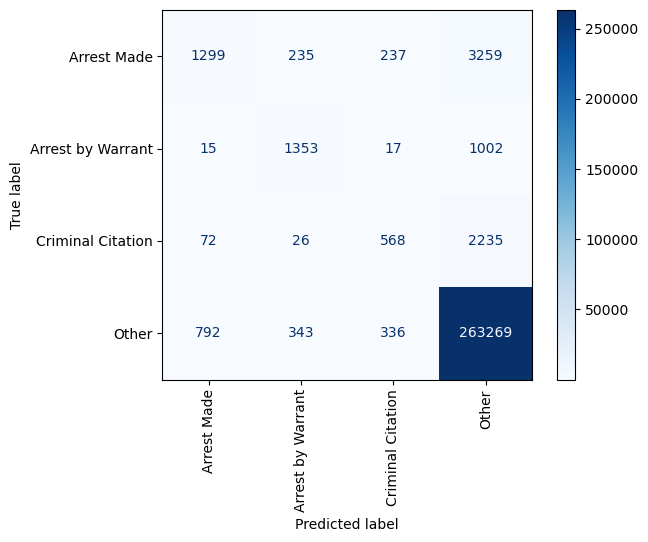

In [142]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

### MLP #2

In [145]:
mlp_model_improved = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model_improved.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [147]:
history = mlp_model_improved.fit(X_train_scaled, y_train, epochs=10, batch_size=128, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9093 - loss: 1.4998 - val_accuracy: 0.9673 - val_loss: 0.1389
Epoch 2/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9657 - loss: 0.1421 - val_accuracy: 0.9666 - val_loss: 0.1398
Epoch 3/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9662 - loss: 0.1391 - val_accuracy: 0.9679 - val_loss: 0.1354


In [148]:
# Make predictions
y_pred_nn_2 = mlp_model_improved.predict(X_test_scaled)
y_pred_nn_2_classes = np.argmax(y_pred_nn_2, axis=1)

# Classification report
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn_2_classes, zero_division=0, target_names=label_names))

8596/8596 ━━━━━━━━━━━━━━━━━━━━ 5s 595us/step
Neural Network Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.30      0.39      5030
Arrest by Warrant       0.67      0.58      0.63      2387
Criminal Citation       0.20      0.00      0.00      2901
            Other       0.97      0.99      0.98    264740

         accuracy                           0.97    275058
        macro avg       0.60      0.47      0.50    275058
     weighted avg       0.96      0.97      0.96    275058



## MLP #3

In [157]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(shape=(X_train_scaled.shape[1],)))
    
    # Tune the number of layers
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=1024, step=32),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0, 0.5, step=0.1)))
    
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='mlp_tuning_2'
)

tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2)

Trial 66 Complete [00h 19m 02s]
val_accuracy: 0.9691929221153259

Best val_accuracy So Far: 0.9698246121406555
Total elapsed time: 08h 10m 59s

Search: Running Trial #67

Value             |Best Value So Far |Hyperparameter
3                 |5                 |num_layers
896               |64                |units_0
0.1               |0.2               |dropout_0
0.00032848        |0.00011137        |learning_rate
576               |64                |units_1
0.3               |0.1               |dropout_1
800               |576               |units_2
0.4               |0.4               |dropout_2
928               |96                |units_3
0.2               |0.1               |dropout_3
608               |416               |units_4
0.3               |0.1               |dropout_4
17                |50                |tuner/epochs
6                 |17                |tuner/initial_epoch
2                 |3                 |tuner/bracket
1                 |3                 |tuner/

In [159]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='mlp_tuning_2'
)

best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from my_dir/mlp_tuning_2/tuner0.json


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [161]:
# Make predictions
y_pred_mlp_3 = best_model.predict(X_test_scaled)
y_pred_mlp_3_classes = np.argmax(y_pred_mlp_3, axis=1)

mlp_3_accuracy = accuracy_score(y_test, y_pred_mlp_3_classes)
mlp_3_recall = recall_score(y_test, y_pred_mlp_3_classes, average='macro')
mlp_3_prec = precision_score(y_test, y_pred_mlp_3_classes, average='macro')
mlp_3_f1 = f1_score(y_test, y_pred_mlp_3_classes, average='macro')

# Classification report
print("MLP #3 Classification Report:")
print(classification_report(y_test, y_pred_mlp_3_classes, zero_division=0, target_names=label_names))

8596/8596 ━━━━━━━━━━━━━━━━━━━━ 4s 430us/step
MLP #3 Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.63      0.25      0.36      5030
Arrest by Warrant       0.69      0.59      0.64      2387
Criminal Citation       0.50      0.29      0.36      2901
            Other       0.98      0.99      0.99    264740

         accuracy                           0.97    275058
        macro avg       0.70      0.53      0.59    275058
     weighted avg       0.96      0.97      0.96    275058



### Convolutional Neural Network

In [165]:
# Reshape the data to be 3D for 1D CNN: (samples, time steps, channels)
# Time steps = number of features, channels = 1
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Build the CNN model
cnn_model = models.Sequential()
cnn_model.add(layers.Input(shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [167]:
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=128, validation_split=0.2,
             callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 225s 33ms/step - accuracy: 0.9665 - loss: 0.1331 - val_accuracy: 0.9693 - val_loss: 0.1169
Epoch 2/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 235s 34ms/step - accuracy: 0.9691 - loss: 0.1154 - val_accuracy: 0.9693 - val_loss: 0.1159
Epoch 3/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 299s 44ms/step - accuracy: 0.9693 - loss: 0.1146 - val_accuracy: 0.9693 - val_loss: 0.1157
Epoch 4/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 328s 48ms/step - accuracy: 0.9695 - loss: 0.1137 - val_accuracy: 0.9696 - val_loss: 0.1147
Epoch 5/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 349s 51ms/step - accuracy: 0.9693 - loss: 0.1142 - val_accuracy: 0.9695 - val_loss: 0.1150
Epoch 6/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 333s 48ms/step - accuracy: 0.9700 - loss: 0.1115 - val_accuracy: 0.9694 - val_loss: 0.1160
Epoch 7/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 323s 47ms/step - accuracy: 0.9699 - loss: 0.1115 - val_accuracy: 0.9693 - val_loss: 0.1154


In [168]:
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test)
cnn_accuracy = test_acc
print(f"Test Accuracy: {test_acc:.2f}")

8596/8596 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9693 - loss: 0.1161
Test Accuracy: 0.97


In [169]:
# Make predictions
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

cnn_recall = recall_score(y_test, y_pred_cnn_classes, average='macro')
cnn_prec = precision_score(y_test, y_pred_cnn_classes, average='macro')
cnn_f1 = f1_score(y_test, y_pred_cnn_classes, average='macro')

# Classification report
print(f"CNN Recall {cnn_recall}")
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn_classes, zero_division=0, target_names=label_names))

8596/8596 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step
CNN Recall 0.5230614518421784
CNN Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.62      0.26      0.36      5030
Arrest by Warrant       0.70      0.59      0.64      2387
Criminal Citation       0.48      0.25      0.33      2901
            Other       0.98      0.99      0.99    264740

         accuracy                           0.97    275058
        macro avg       0.69      0.52      0.58    275058
     weighted avg       0.96      0.97      0.96    275058



### CNN #2
Trying out a slightly different convolutional neural network.

In [171]:
# Build the CNN model
cnn_model_2 = models.Sequential()
cnn_model_2.add(layers.Input(shape=(X_train_cnn.shape[1], 1)))
cnn_model_2.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model_2.add(layers.MaxPooling1D(pool_size=2))
cnn_model_2.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model_2.add(layers.MaxPooling1D(pool_size=2))
cnn_model_2.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model_2.add(layers.MaxPooling1D(pool_size=2))
cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(100, activation='relu'))
cnn_model_2.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
cnn_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [172]:
cnn_model_2.fit(X_train_cnn, y_train, epochs=10, batch_size=128, validation_split=0.2,
                callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 454s 66ms/step - accuracy: 0.9667 - loss: 0.1339 - val_accuracy: 0.9687 - val_loss: 0.1176
Epoch 2/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 419s 61ms/step - accuracy: 0.9686 - loss: 0.1178 - val_accuracy: 0.9688 - val_loss: 0.1172
Epoch 3/10
6877/6877 ━━━━━━━━━━━━━━━━━━━━ 416s 61ms/step - accuracy: 0.9690 - loss: 0.1154 - val_accuracy: 0.9690 - val_loss: 0.1155


In [173]:
# Make predictions
y_pred_cnn_2 = cnn_model_2.predict(X_test_cnn)
y_pred_cnn_2_classes = np.argmax(y_pred_cnn_2, axis=1)

cnn_2_accuracy = accuracy_score(y_test, y_pred_cnn_2_classes)
cnn_2_recall = recall_score(y_test, y_pred_cnn_2_classes, average='macro')
cnn_2_prec = precision_score(y_test, y_pred_cnn_2_classes, average='macro')
cnn_2_f1 = f1_score(y_test, y_pred_cnn_2_classes, average='macro')

# Classification report
print(f"CNN2 Recall {cnn_2_recall}")
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn_2_classes, zero_division=0, target_names=label_names))

8596/8596 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step
CNN2 Recall 0.4871836737849423
CNN Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.54      0.28      0.37      5030
Arrest by Warrant       0.69      0.58      0.63      2387
Criminal Citation       0.53      0.09      0.15      2901
            Other       0.98      0.99      0.99    264740

         accuracy                           0.97    275058
        macro avg       0.69      0.49      0.54    275058
     weighted avg       0.96      0.97      0.96    275058



### CNN #3

In [175]:
cnn_model_3 = models.Sequential()
cnn_model_3.add(layers.Input(shape=(X_train_cnn.shape[1], 1)))
cnn_model_3.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model_3.add(layers.MaxPooling1D(pool_size=2))
cnn_model_3.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model_3.add(layers.Dropout(0.5))  # Add after Conv or Dense layers
cnn_model_3.add(layers.MaxPooling1D(pool_size=2))
cnn_model_3.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model_3.add(layers.Dropout(0.5))  # Add after Conv or Dense layers
cnn_model_3.add(layers.MaxPooling1D(pool_size=2))
cnn_model_3.add(layers.Flatten())
cnn_model_3.add(layers.Dense(100, activation='relu'))
cnn_model_3.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
cnn_model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [176]:
cnn_model_3.fit(X_train_cnn, y_train, epochs=10, batch_size=256, validation_split=0.2,
               callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 474s 137ms/step - accuracy: 0.9636 - loss: 0.1472 - val_accuracy: 0.9689 - val_loss: 0.1437
Epoch 2/10
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 476s 138ms/step - accuracy: 0.9679 - loss: 0.1221 - val_accuracy: 0.9691 - val_loss: 0.1364
Epoch 3/10
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 478s 139ms/step - accuracy: 0.9684 - loss: 0.1195 - val_accuracy: 0.9688 - val_loss: 0.1248


In [177]:
# Make predictions
y_pred_cnn_3 = cnn_model_3.predict(X_test_cnn)
y_pred_cnn_3_classes = np.argmax(y_pred_cnn_3, axis=1)

cnn_3_accuracy = accuracy_score(y_test, y_pred_cnn_3_classes)
cnn_3_recall = recall_score(y_test, y_pred_cnn_3_classes, average='macro')
cnn_3_prec = precision_score(y_test, y_pred_cnn_3_classes, average='macro')
cnn_3_f1 = f1_score(y_test, y_pred_cnn_3_classes, average='macro')

# Classification report
print(f"CNN3 F1 {cnn_3_f1}")
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn_3_classes, zero_division=0, target_names=label_names))

8596/8596 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step
CNN3 F1 0.5650677936156169
CNN Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.63      0.23      0.33      5030
Arrest by Warrant       0.68      0.59      0.63      2387
Criminal Citation       0.45      0.23      0.31      2901
            Other       0.98      0.99      0.99    264740

         accuracy                           0.97    275058
        macro avg       0.68      0.51      0.57    275058
     weighted avg       0.96      0.97      0.96    275058



## Results

In [203]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)
mlp_2_accuracy = accuracy_score(y_test, y_pred_nn_2_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')
mlp_2_recall = recall_score(y_test, y_pred_nn_2_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)
mlp_2_prec = precision_score(y_test, y_pred_nn_2_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')
mlp_2_f1 = f1_score(y_test, y_pred_nn_2_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP1', 'MLP2', 'MLP3', 'CNN1', 'CNN2', 'CNN3'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, mlp_2_accuracy, mlp_3_accuracy, cnn_accuracy, cnn_2_accuracy, cnn_3_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, mlp_2_recall, mlp_3_recall, cnn_recall, cnn_2_recall, cnn_3_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, mlp_2_prec, mlp_3_prec, cnn_prec, cnn_2_prec, cnn_3_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, mlp_2_f1, mlp_3_f1, cnn_f1, cnn_2_f1, cnn_3_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.962488,0.250000,0.240622,0.245221
Logistic Regression,0.969396,0.513951,0.691921,0.571131
Random Forest,0.957442,0.503261,0.521498,0.507291
MLP1,0.968847,0.503827,0.688551,0.562082
MLP2,0.967549,0.469603,0.600936,0.500041
MLP3,0.969923,0.529908,0.699869,0.586328
CNN1,0.969595,0.523061,0.692655,0.579459
CNN2,0.968741,0.487184,0.685626,0.535631
CNN3,0.968970,0.511344,0.684971,0.565068
